# Basics of XGA profiles - focusing on cluster surface brightness

Here the aim is to go through the basic capabilities of XGA profile products, with a focus on the generation of surface brightness profiles of galaxy clusters. A demonstration of the fitting functionality built into XGA profiles will be given, which will include an exploration of the XGA model classes and their purpose. I'll also show how we can view profiles (both for individually and together), and run through the user-configurable options built into the view method. 

In [1]:
from xga.sources import GalaxyCluster

from astropy.units import Quantity

Firstly, I will define a GalaxyCluster source for Abell 907, a cluster for which I know high quality data is available. **Again, please note that the overdensity radius and redshift that I've used here are approximate and should not be used for a scientific analysis**:

In [2]:
src = GalaxyCluster(149.59209, -11.05972, 0.16, r500=Quantity(1200, 'kpc'), name='A907')
src.info()


-----------------------------------------------------
Source Name - A907
User Coordinates - (149.59209, -11.05972) degrees
X-ray Peak - (149.59251340970866, -11.063958320861634) degrees
nH - 0.0534 1e+22 / cm2
Redshift - 0.16
XMM ObsIDs - 3
PN Observations - 3
MOS1 Observations - 3
MOS2 Observations - 3
On-Axis - 3
With regions - 3
Total regions - 69
Obs with one match - 3
Obs with >1 matches - 0
Images associated - 18
Exposure maps associated - 18
Combined Ratemaps associated - 1
Spectra associated - 0
R500 - 1200.0 kpc
R500 SNR - 251.61
-----------------------------------------------------



## Generating and viewing a surface brightness profile

A [convenient method](../../xga.sources.html#xga.extended.GalaxyCluster.view_brightness_profile) for quickly generating and viewing cluster surface brightness profiles has been implemented in the GalaxyCluster source class, with the main input being the desired outer radius of the brightness profile in question. In this demonstration I have made a profile out to the approximate R$_{500}$ that I supplied on declaration, and by default this method has used the combined brightness profile to do so:

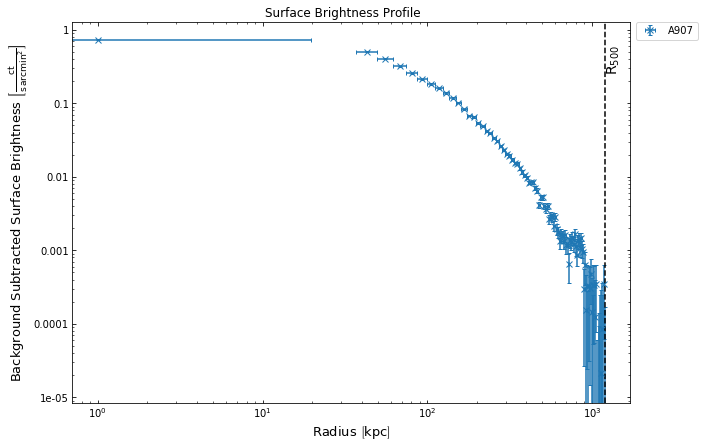

In [3]:
src.view_brightness_profile('r500')